# Legal Judgement Predictor - A classification task on BERT embeddings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

path_to_datasets = 'embeddings_datasets/legal-bert-base-uncased/'
create_dataset = False

## Preprocessing

In [2]:
class ECHRDataset(Dataset):
        def __init__(self, data, attention_mask, labels):
            self.data = data
            self.attention_mask = attention_mask
            self.labels = labels

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.attention_mask[idx], self.labels[idx]

In [3]:
if create_dataset:
        
    # pad the data to be of the same shape
    def pad_data(data, max_len):
        padded_data = []
        attention_masks = []
        for i in range(len(data)):
            attention_masks.append([1] * data[i].shape[0] + [0] * (max_len - data[i].shape[0]))
            padded_data.append(F.pad(data[i], (0, 0, 0, max_len - data[i].shape[0])))
        #print(len(attention_masks))
        return torch.stack(padded_data), torch.tensor(attention_masks)

    # load data
    train = torch.load('embeddings/legal-bert-base-uncased/emb_tr_cpu.pkl')
    dev = torch.load('embeddings/legal-bert-base-uncased/emb_dev_cpu.pkl')
    test = torch.load('embeddings/legal-bert-base-uncased/emb_test_cpu.pkl')

    print('Train '+str(len(train)),'Dev '+str(len(dev)), 'Test '+str(len(test)))
    
    # concat dev to train series
    train = np.concatenate((train, dev))

    print('Train + Dev = '+str(len(train)))

    # load labels
    train_labels = pd.read_pickle('embeddings/legal-bert-base-uncased/train_labels.pkl')
    dev_labels = pd.read_pickle('embeddings/legal-bert-base-uncased/dev_labels.pkl')
    test_labels = pd.read_pickle('embeddings/legal-bert-base-uncased/test_labels.pkl')

    # concat dev labels to train labels
    train_labels = torch.tensor(np.concatenate((train_labels, dev_labels)))

    # pad the data
    max_len_train = max([x.shape[0] for x in train])
    max_len_test = max([x.shape[0] for x in test])
    train, train_attention_masks = pad_data(train, max_len_train)
    test, test_attention_masks = pad_data(test, max_len_test)

    # create the datasets
    train_dataset = ECHRDataset(train, train_attention_masks, train_labels)
    test_dataset = ECHRDataset(test, test_attention_masks, test_labels)

    print (train_dataset.data.device)

    # save the datasets
    if not os.path.exists(path_to_datasets):
        os.makedirs(path_to_datasets)
    torch.save(train_dataset, path_to_datasets+'train_dataset.pt')
    torch.save(test_dataset, path_to_datasets+'test_dataset.pt')


In [4]:
if not create_dataset:
    train_dataset = torch.load(path_to_datasets+'train_dataset.pt')
    test_dataset = torch.load(path_to_datasets+'test_dataset.pt')
    print(len(train_dataset))

8480


## Baseline

(8480, 768)


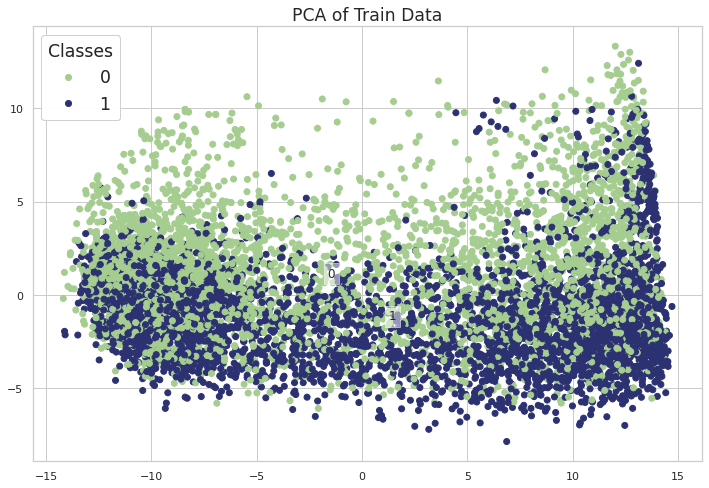

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
first_chunk_train = np.array([x[0].numpy() for x in train_dataset.data])
first_chunk_test = np.array([x[0].numpy() for x in test_dataset.data])

print(first_chunk_train.shape)

pca = PCA(n_components=2)
xpca = pca.fit_transform(first_chunk_train)

fig = plt.figure(figsize=(12, 8))

# Scatter plot
scatter = plt.scatter(xpca[:, 0], xpca[:, 1], c=train_dataset.labels, cmap='crest')

# Get legend handles and labels
legend1 = plt.legend(*scatter.legend_elements(), title="Classes", fontsize = 'x-large', title_fontsize = 'x-large')

# Add legend to the plot
plt.gca().add_artist(legend1)
# Get unique class labels
unique_labels = np.unique(train_dataset.labels)
# Add custom labels for class 0 and class 1
for label in unique_labels:
    plt.text(xpca[train_dataset.labels == label, 0].mean(), xpca[train_dataset.labels == label, 1].mean(), str(label),
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', alpha=0.5))

plt.title('PCA of Train Data', fontsize='x-large')

plt.show()

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Initializing the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier
rf_classifier.fit(first_chunk_train, train_dataset.labels)

# Predicting on the test set
y_pred = rf_classifier.predict(first_chunk_test)

# Calculating metrics
f1 = f1_score(test_dataset.labels, y_pred, average='weighted')
print(classification_report(test_dataset.labels, y_pred))
print("Random Forest F1:", f1)


              precision    recall  f1-score   support

           0       0.66      0.54      0.59      1024
           1       0.78      0.85      0.82      1974

    accuracy                           0.75      2998
   macro avg       0.72      0.70      0.70      2998
weighted avg       0.74      0.75      0.74      2998

Random Forest F1: 0.73960337479736


In [26]:
from sklearn.svm import SVC

# Initializing the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Training the classifier
svm_classifier.fit(first_chunk_train, train_dataset.labels)

# Predicting on the test set
y_pred_svm = svm_classifier.predict(first_chunk_test)

# Calculating metrics
f1 = f1_score(test_dataset.labels, y_pred_svm, average='weighted')
print(classification_report(test_dataset.labels, y_pred_svm))
print("SVM F1:", f1)

              precision    recall  f1-score   support

           0       0.77      0.59      0.67      1024
           1       0.81      0.91      0.86      1974

    accuracy                           0.80      2998
   macro avg       0.79      0.75      0.76      2998
weighted avg       0.80      0.80      0.79      2998

SVM F1: 0.7938613853836507


<AxesSubplot:>

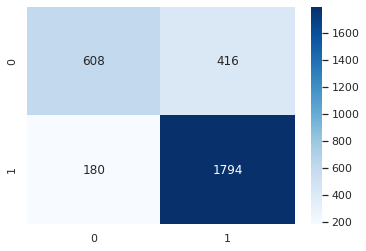

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_dataset.labels, y_pred_svm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')


In [67]:
from sklearn.neural_network import MLPClassifier

# Initializing the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(16,), max_iter=200, learning_rate='adaptive', random_state=42)

# Training the classifier
mlp_classifier.fit(first_chunk_train, train_dataset.labels)

# Predicting on the test set
y_pred_mlp = mlp_classifier.predict(first_chunk_test)

# Calculating metrics
f1 = f1_score(test_dataset.labels, y_pred_mlp, average='weighted')
print(classification_report(test_dataset.labels, y_pred_mlp))
print("MLP F1:", f1)

              precision    recall  f1-score   support

           0       0.80      0.54      0.65      1024
           1       0.80      0.93      0.86      1974

    accuracy                           0.80      2998
   macro avg       0.80      0.74      0.75      2998
weighted avg       0.80      0.80      0.79      2998

MLP F1: 0.787049658982523


/usr/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## AttentionMLP Model

In [69]:
# check if windows or macos
if (torch.cuda.is_available()):
    print("Running on GPU")
    device = torch.device('cuda',1)
elif (torch.backends.mps.is_available()):
    print("Running on MPS")
    device = torch.device('mps')
else :
    print("Running on CPU")
    device = torch.device('cpu')

train_dataset.data = train_dataset.data.to(device)
train_dataset.labels = train_dataset.labels.to(device)
train_dataset.attention_mask = train_dataset.attention_mask.to(device)

test_dataset.data = test_dataset.data.to(device)
test_dataset.labels = test_dataset.labels.to(device)
test_dataset.attention_mask = test_dataset.attention_mask.to(device)

train_dataset.data.device

Running on GPU


device(type='cuda', index=1)

In [70]:
class AttentionMLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout=0, weight_decay=0.01):
        super(AttentionMLP, self).__init__()
        # vector for query attention
        self.selector = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.Value= nn.Linear(input_dim, input_dim, bias=False)
        self.Key = nn.Linear(input_dim, input_dim, bias=False)
        # mlp layers
        layers = []
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_sizes[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, attention_mask=None):
        # attention
        key = self.Key(x)

        value = self.Value(x)

        non_normalized_attention = torch.matmul(key, self.selector)
        if attention_mask is not None:
            attention_mask=attention_mask.unsqueeze(2)

            non_normalized_attention = non_normalized_attention.masked_fill(attention_mask == 0, -1e9)
        attention = F.softmax(non_normalized_attention, dim=1)
        # permute the attention to match the shape of the value
        attention = attention.permute(0, 2, 1)

        x = torch.matmul(attention, value)

        # mlp
        x = self.mlp(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x.flatten()


In [71]:
from src.utils import k_fold_attention
model = AttentionMLP(768, [768,16])
model = model.to(device)
results = k_fold_attention ( model, 
                  criterion=nn.BCELoss(), 
                  optimizer=optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001),
                  train_dataset= train_dataset, 
                  k_folds=4, 
                  epochs=50, 
                  batch_size=64 )

Fold 1/4
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [00:45<00:00,  1.10epoch/s, Train Loss=0.336, Val Loss=0.353, Val Acc=0.839, Val F1=0.844]


Fold 2/4
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [00:44<00:00,  1.12epoch/s, Train Loss=0.324, Val Loss=0.339, Val Acc=0.858, Val F1=0.865]


Fold 3/4
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [00:44<00:00,  1.12epoch/s, Train Loss=0.346, Val Loss=0.401, Val Acc=0.811, Val F1=0.813]


Fold 4/4
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [00:43<00:00,  1.15epoch/s, Train Loss=0.308, Val Loss=0.36, Val Acc=0.845, Val F1=0.858] 


In [72]:
# print mean val loss and acc over fold 
loss = 0
acc = 0
f1 = 0
for key,value in results.items():
    loss += value['result']['best_val_loss']
    acc += value['result']['best_val_acc']
    f1 += value['result']['best_val_f1']

print('avg val loss: ', loss/len(results))
print('avg val acc: ', acc/len(results))
print('avg val f1: ', f1/len(results))

avg val loss:  0.3428617046378991
avg val acc:  0.8481132075471698
avg val f1:  0.8573315092441628


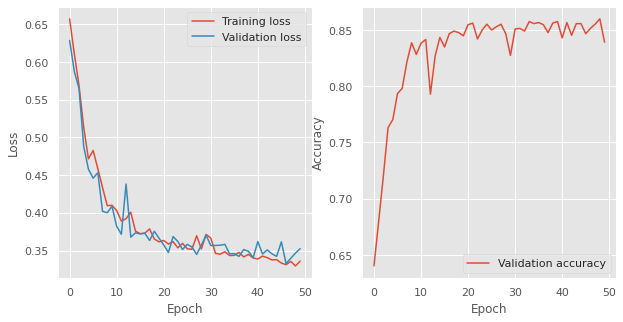

In [77]:
fold = 1
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(results[fold]['stats']['train_losses'], label='Training loss')
ax[0].plot(results[fold]['stats']['val_losses'], label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(results[fold]['stats']['val_accs'], label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

# RnnMLP

In [78]:
train_dataset.attention_mask = train_dataset.attention_mask.to('cpu')

class RNNHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, hidden_dim_mlp, output_dim, dropout=0, bidirectional=False):
        super(RNNHead, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim, hidden_dim_mlp)
        self.fc2 = nn.Linear(hidden_dim_mlp, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    
    def forward(self, x, lengths):
        # pack the padded sequence
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        # forward pass through LSTM
        out, (h_n, c_n) = self.rnn(x)
        # unpack the packed sequence
        output= self.fc(h_n[-1])
        output=self.relu(output)
        output= self.dropout(output)
        output = self.fc2(output)
        output=self.sigmoid(output)
        return output.flatten()

In [91]:
from src.utils import k_fold_rnn
# create the model
model = RNNHead(768, 768, 2, 16, 1, dropout=0.1)
model = model.to(device)
results2 = k_fold_rnn(model, 
            criterion=nn.BCELoss(), 
            optimizer=optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4), 
            train_dataset=train_dataset, 
            k_folds=4, 
            epochs=50, 
            batch_size=128)

Fold 1/4
Reset trainable parameters of layer = LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.1)
Reset trainable parameters of layer = Linear(in_features=768, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [01:27<00:00,  1.75s/epoch, Train Loss=0.285, Val Loss=0.324, Val Acc=0.844, Val F1=0.861]


Fold 2/4
Reset trainable parameters of layer = LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.1)
Reset trainable parameters of layer = Linear(in_features=768, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [01:25<00:00,  1.71s/epoch, Train Loss=0.345, Val Loss=0.318, Val Acc=0.861, Val F1=0.869]


Fold 3/4
Reset trainable parameters of layer = LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.1)
Reset trainable parameters of layer = Linear(in_features=768, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [01:27<00:00,  1.74s/epoch, Train Loss=0.289, Val Loss=0.35, Val Acc=0.844, Val F1=0.86]  


Fold 4/4
Reset trainable parameters of layer = LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.1)
Reset trainable parameters of layer = Linear(in_features=768, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [01:26<00:00,  1.74s/epoch, Train Loss=0.29, Val Loss=0.369, Val Acc=0.848, Val F1=0.855] 


In [92]:
# print mean val loss and acc over fold 
loss = 0
acc = 0
f1 = 0
for key,value in results2.items():
    loss += value['result']['best_val_loss']
    acc += value['result']['best_val_acc']
    f1 += value['result']['best_val_f1']

print('avg val loss: ', loss/len(results))
print('avg val acc: ', acc/len(results))
print('avg val f1: ', f1/len(results))

avg val loss:  0.3309389387860018
avg val acc:  0.852122641509434
avg val f1:  0.8657772016770872


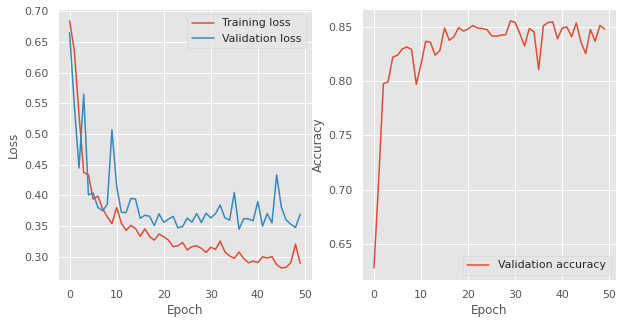

In [97]:
fold = 4

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(results2[fold]['stats']['train_losses'], label='Training loss')
ax[0].plot(results2[fold]['stats']['val_losses'], label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(results2[fold]['stats']['val_accs'], label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

# Test the best model

In [ ]:
model = AttentionMLP(768, [768,16])
model = model.to(device)
criterion=nn.BCELoss(), 
optimizer=optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001),
epochs=50, 
batch_size=64

In [ ]:
# test the best model
criterion = nn.BCELoss()

from sklearn.metrics import classification_report
with torch.no_grad():
    outputs = model(test_dataset.data, test_dataset.attention_mask)
    loss = criterion(outputs, test_dataset.labels.float())
    print(f'Test loss: {loss.item()}')
    print(classification_report(test_dataset.labels.cpu(), (outputs > 0.5).cpu()))
    # confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(test_dataset.labels.cpu(), (outputs > 0.5).cpu())
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()